In [15]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
import warnings
warnings.filterwarnings('ignore')

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [17]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("./data/yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [18]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

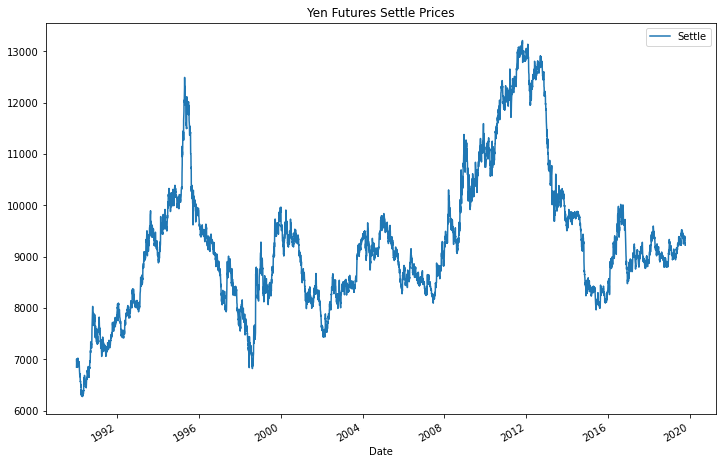

In [19]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!
yen_futures[["Settle"]].plot(figsize=(12, 8), title="Yen Futures Settle Prices")
ax.legend(['Yen Future Settle Price'])
ax.plot();
# save the plot for markdown report 
#plt.title("Yen Futures Settle Prices")
plt.savefig('../Images/Graphs/Yen_futures.jpg')

 ## Answer 
 * Do you see any patterns, long-term and/or short?
 * Looking at the plot, in the long-term, the Yen has strengthened against in the long term. In the middleterm, there has been some weakenss (after 20-12). In the shorterm, there seems to be a range bound fluctuation.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [20]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
hp_noise, hp_trend = sm.tsa.filters.hpfilter(yen_futures["Settle"])

In [21]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
df_yen_futures = yen_futures[["Settle"]].copy()
df_yen_futures["noise"] = hp_noise
df_yen_futures["trend"] = hp_trend
df_yen_futures.head()

,Settle,noise,trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


In [22]:
df_yen_futures[["Settle", "trend"]]["2015-01-01":]

,Settle,trend
Date,,
2015-01-02,8315.0,8394.686404
2015-01-05,8371.0,8401.395762
2015-01-06,8435.0,8408.585597
2015-01-07,8412.0,8416.089059
2015-01-08,8360.0,8423.755805
...,...,...
2019-10-09,9338.0,9313.060753
2019-10-10,9303.5,9309.368559
2019-10-11,9251.0,9305.454594


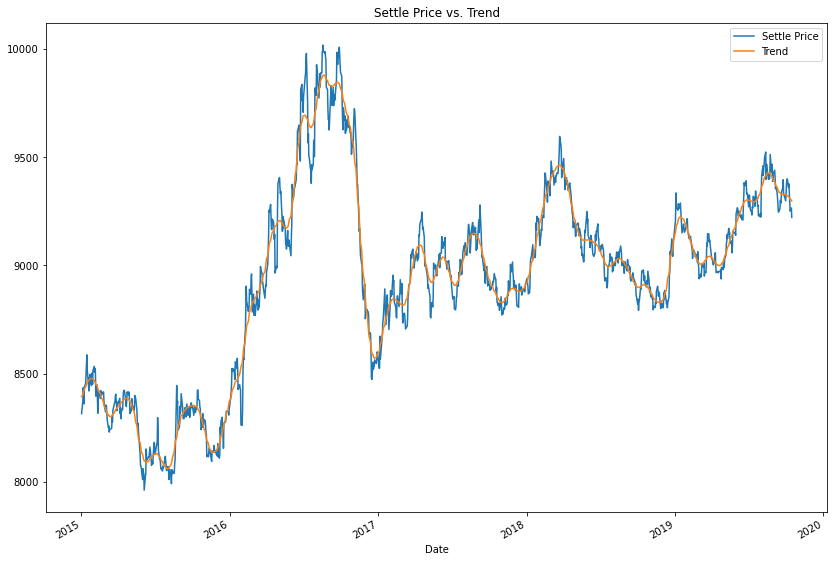

In [23]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# create dataframe for the data required
df_2015_to_present = df_yen_futures[["Settle", "trend"]]["2015-01-01":]
# plot labels
labels = ["Settle Price", "Trend"]
ax = df_2015_to_present.plot(title="Settle Price vs. Trend", figsize=(14, 10))
ax.legend(labels)
#plot 
ax.plot();
# save the plot for markdown report 
plt.savefig('../Images/Graphs/Settle_Trend.jpg')

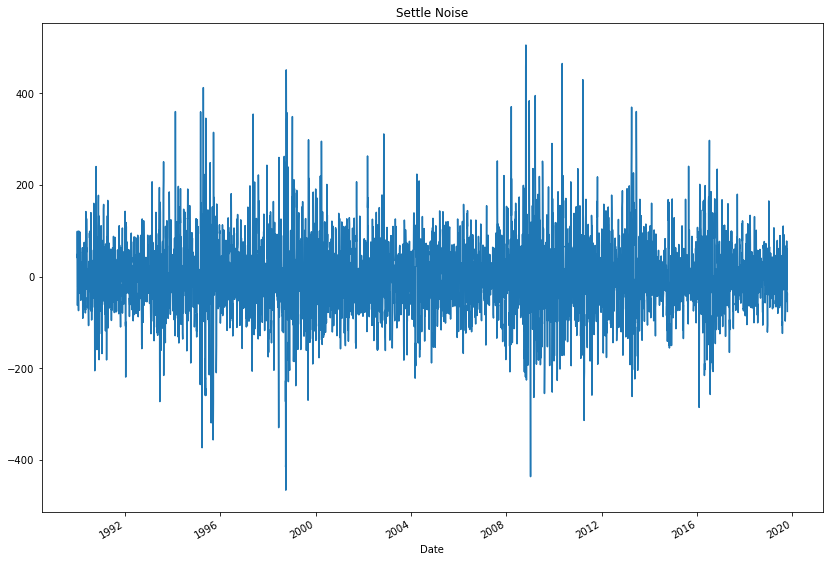

In [24]:
# Plot the Settle Noise
# YOUR CODE HERE!
hp_noise.plot( title="Settle Noise",figsize=(14, 10));
# save the plot for markdown report 
plt.savefig('../Images/Graphs/Settle_Noise.jpg')

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [25]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# get returns 
returns = (yen_futures[["Settle"]].pct_change() * 100)
# replace np infinity with null and drop all nulls
returns = returns.replace(-np.inf, np.nan).dropna()
returns.head()

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275


In [26]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = sm.tsa.ARMA(returns, order=(2, 1))

# Fit the model and assign it to a variable called results
arma_results = model.fit()

C:\Python\anaconda\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [27]:
# Output model summary results:
print(arma_results.summary())

                              ARMA Model Results                              
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 29 Apr 2021   AIC                          15798.142
Time:                        23:19:27   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3063      1.277     -0.240      0.810      -2.810       2.197
ar.L2.Settle    -0.0019      0.019     -0.09

## Answer 
* Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
* The model is not a good fit as all the p value are greater than 0.05

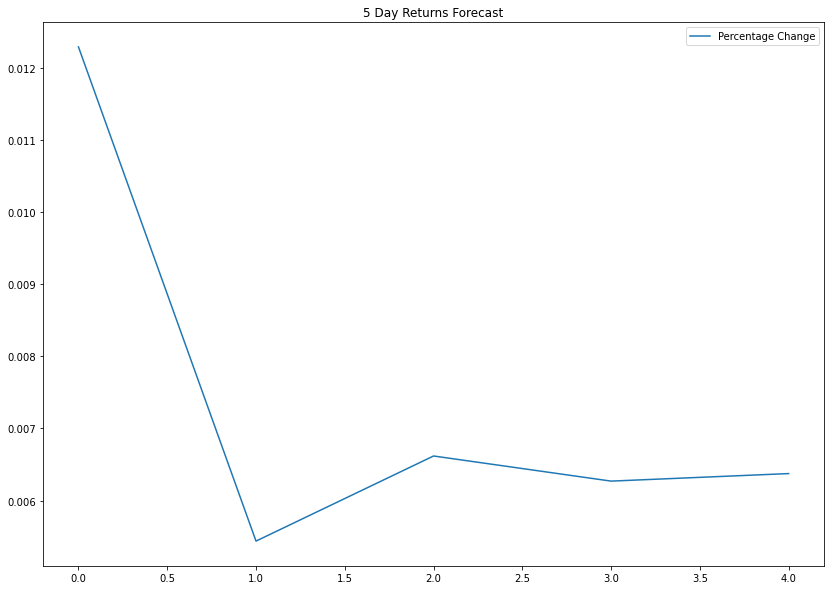

In [28]:
# Plot the 5 Day Returns Forecast
five_day_forecast = pd.DataFrame(arma_results.forecast(steps=5)[0])
ax= five_day_forecast.plot(title="5 Day Returns Forecast",figsize=(14, 10))
ax.legend(["Percentage Change"])
ax.plot();
# save the plot for markdown report 
plt.savefig('../Images/Graphs/five_days_forecast.jpg')

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [29]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(yen_futures[["Settle"]], order=(5, 1, 1))
# Fit the model
results_arima = model.fit()

C:\Python\anaconda\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Python\anaconda\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [30]:
# Output model summary results:
print(results_arima.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 29 Apr 2021   AIC                          83905.238
Time:                        23:19:29   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3163      0.700      0.452      0.651      -1.056       1.688
ar.L1.D.Settle     0.2821      0.699      0.403      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016

## Answer 
 * Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 * The model is not a good fit as all the the p values are greater than 0.05

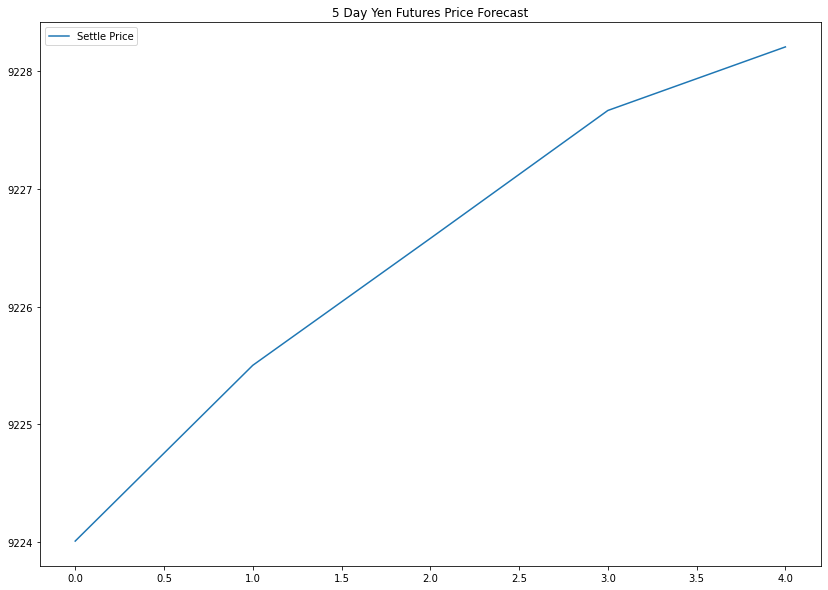

In [31]:
# Plot the 5 Day Price Forecast
# create data frame with 5 day forecast
df_arima_forecast = pd.DataFrame(results_arima.forecast(steps=5)[0] )
ax= df_arima_forecast.plot(title="5 Day Yen Futures Price Forecast",figsize=(14, 10))
ax.legend(["Settle Price"],loc=2)
ax.plot();
# save the plot for markdown report 
plt.savefig('../Images/Graphs/five_day_forecast_arima.jpg')

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [32]:
import arch 

In [33]:
# Estimate a GARCH model:
model = arch.arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)
# Fit the model
results_arch = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 87510785.45716049
Iteration:      2,   Func. Count:     14,   Neg. LLF: 8220.92713535338
Iteration:      3,   Func. Count:     22,   Neg. LLF: 7487.706274033166
Iteration:      4,   Func. Count:     28,   Neg. LLF: 7505.857088437436
Iteration:      5,   Func. Count:     34,   Neg. LLF: 7479.053903182994
Iteration:      6,   Func. Count:     40,   Neg. LLF: 7895.885813879309
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7462.418448377437
Iteration:      8,   Func. Count:     52,   Neg. LLF: 7462.214153928055
Iteration:      9,   Func. Count:     57,   Neg. LLF: 7462.021586253446
Iteration:     10,   Func. Count:     62,   Neg. LLF: 7461.935968239088
Iteration:     11,   Func. Count:     67,   Neg. LLF: 7461.927898370626
Iteration:     12,   Func. Count:     72,   Neg. LLF: 7461.927643544426
Iteration:     13,   Func. Count:     77,   Neg. LLF: 7461.927640079675
Iteration:     14,   Func. Count:     81,   Neg. LLF: 7461.927640

In [34]:
# Summarize the model results
print(results_arch.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14931.9
Method:            Maximum Likelihood   BIC:                           14959.6
                                        No. Observations:                 7514
Date:                Thu, Apr 29 2021   Df Residuals:                     7514
Time:                        23:19:30   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      4.2896e-03  2.057e-03      2.085  3.708e-02 

## Answer
* Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
* This model is not a good fit, though it is better than the others; all pvalues are greater than 0.05 except the beta[1]



In [35]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [36]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results_arch.forecast(start=last_day, horizon=forecast_horizon)

In [37]:
# Annualize the forecast
annual_forecast = np.sqrt(forecasts.variance.dropna() * 252)
annual_forecast.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434048,7.475745,7.516867,7.557426,7.597434


In [38]:
# Transpose the forecast so that it is easier to plot
df_annual_forecast = annual_forecast.dropna().T
#rename column to correct value from date
df_annual_forecast.columns = ["Volatility"]
df_annual_forecast.head()

,Volatility
h.1,7.434048
h.2,7.475745
h.3,7.516867
h.4,7.557426
h.5,7.597434


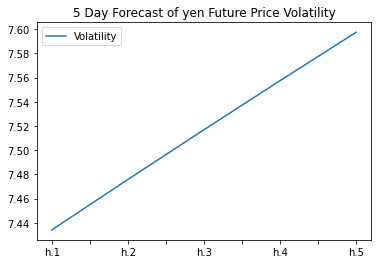

In [39]:
# Plot the final forecast
df_annual_forecast.plot(title="5 Day Forecast of yen Future Price Volatility");
# save the plot for markdown report 
plt.savefig('../Images/Graphs/five_day_volatility_GARCH.jpg')

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

# Answers

* Based on our time series analysis, I would buy the yen on 2019-10-15 and sell after five days.The five day forecast shows that it will rise. Data to buy now is not available for anlaysis. 

* The risk of the yen is expected to increase, depicted by GARCH predicted volatality is increasing 

* I would not feel confident in using the models as they are and would look at improving them to bring down the p values. 

#### Code below is used to export all models' reports to image format

In [40]:
# Exporting reports to image file to show in markdown
from PIL import Image, ImageDraw, ImageFont


In [44]:
# dictionary of reports 
reports = {"arma" :arma_results.summary().as_text() ,"arima" :results_arima.summary().as_text(), "arch" : results_arch.summary().as_text() ,}
#generate image for each report
for rep in reports:
    fname = rep +"_report.jpg"
    fpath = "../Images/Reports/" + fname
    img = Image.new('RGB', (600, 500), color = 'white')
    color = 'rgb(0, 62, 126)' # royal blue color
    d1 = ImageDraw.Draw(img)
    d1.text((20, 10), reports[rep], fill=color)
    img.save(fpath)
